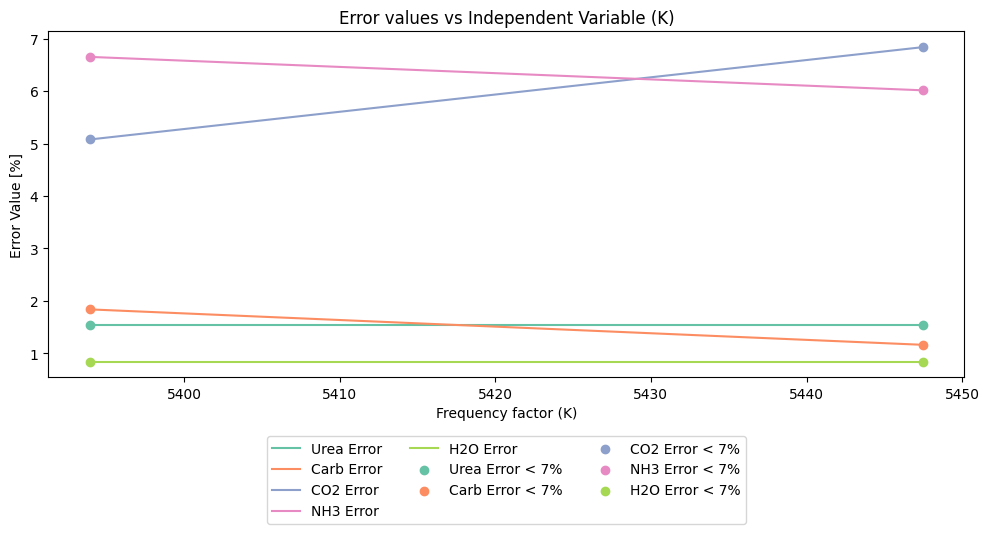

In [1]:
# Import necessary libraries
import os
import win32com.client as win32  # For COM connection with Aspen Plus
import numpy as np  # For numerical calculations
import time  # To pause code execution for Aspen run completion
import pandas as pd  # To create and manipulate dataframes
import matplotlib.pyplot as plt  # For creating plots

# Define the Aspen Plus simulation file path
Aspenfilepath = r'Template_carb\Urea_reactor_biuret.bkp'

# Create a COM connection with Aspen Plus
Aspen = win32.Dispatch('Apwn.document')
Aspen.InitFromArchive2(os.path.abspath(Aspenfilepath))  # Initialize simulation from the file
Aspen.Engine.Run2()  # Run the simulation
Aspen.Visible = True  # Optional: Make the Aspen window visible
Aspen.SuppressDialogs = 1  # Suppress dialogs to avoid interruptions

# Define the Aspen data nodes for different mass fractions and reaction parameters
K_node = r'\Data\Reactions\Reactions\R2\Input\PRE_EXP\1'
Urea_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\UREA'
Carb_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\CARB'
CO2_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\CO2'
NH3_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\NH3'
H2O_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\H2O'
Biuret_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\BIURETU'

# Define the range of K (frequency factor) to test
K_array = np.linspace(1700, 7000, 100)

# Initialize lists to store the mass fractions at each K value
Urea, Carb, CO2, NH3, H2O, Biuret = [], [], [], [], [], []

# Loop through each K value, update the Aspen model, and retrieve mass fractions
for k in K_array:
    Aspen.Tree.FindNode(K_node).Value = float(k)  # Set the frequency factor
    Aspen.Engine.Run2()  # Run the Aspen simulation

    # Wait until the simulation is finished
    while Aspen.Engine.IsRunning:
        time.sleep(0.5)

    # Retrieve the mass fractions for each component
    Urea.append(Aspen.Tree.FindNode(Urea_mass_fraction_node).Value)
    Carb.append(Aspen.Tree.FindNode(Carb_mass_fraction_node).Value)
    CO2.append(Aspen.Tree.FindNode(CO2_mass_fraction_node).Value)
    NH3.append(Aspen.Tree.FindNode(NH3_mass_fraction_node).Value)
    H2O.append(Aspen.Tree.FindNode(H2O_mass_fraction_node).Value)
    Biuret.append(Aspen.Tree.FindNode(Biuret_mass_fraction_node).Value)

# Close the Aspen Plus connection
Aspen.Close()

# Function to calculate percentage error between measured and reference values
def Calculate_percentage_error(measured, reference):
    return np.abs((measured - reference) / reference) * 100

# Define reference mass fractions for comparison (urea, carb, CO2, NH3, H2O, biuret)
Reference_mass_frac = np.array([0.00126236828037646, 0.545746242227888, 0.11804232374056, 0.252436689248328, 0.0712285977656909, 0])

# Calculate percentage errors for each component
Error_urea = Calculate_percentage_error(Urea, Reference_mass_frac[0])
Error_carb = Calculate_percentage_error(Carb, Reference_mass_frac[1])
Error_co2 = Calculate_percentage_error(CO2, Reference_mass_frac[2])
Error_nh3 = Calculate_percentage_error(NH3, Reference_mass_frac[3])
Error_h2o = Calculate_percentage_error(H2O, Reference_mass_frac[4])
Error_biuret = np.ones(100) * 100  # Assume 100% error for biuret as reference is zero

# Filter results where carbamate mass fraction is within the desired range (0.5 to 0.54)
Filtered_indices = (np.array(Carb) >= 0.5) & (np.array(Carb) <= 0.54)

# Extract filtered errors for each component
Filtered_error_urea = Error_urea[Filtered_indices]
Filtered_error_carb = Error_carb[Filtered_indices]
Filtered_error_co2 = Error_co2[Filtered_indices]
Filtered_error_nh3 = Error_nh3[Filtered_indices]
Filtered_error_h2o = Error_h2o[Filtered_indices]

# Create a dataframe with filtered errors
filtered_data = {
    'Index': np.where(Filtered_indices)[0],
    'Urea Error': Filtered_error_urea,
    'Carb Error': Filtered_error_carb,
    'CO2 Error': Filtered_error_co2,
    'NH3 Error': Filtered_error_nh3,
    'H2O Error': Filtered_error_h2o
}

df_filtered = pd.DataFrame(filtered_data).set_index('Index')

# Filter rows where all errors are below 7% for line plot
df_lines = df_filtered[(df_filtered < 7).all(axis=1)]
line_indexes = df_lines.index

# Create a colormap for plots
colors = plt.get_cmap('Set2')

# Plot line chart for errors below 7%
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_lines.columns):
    plt.plot(K_array[line_indexes], df_lines[col], label=col, color=colors(i))

# Filter rows where all errors are below 7% for scatter plot
df_dots = df_filtered[(df_filtered < 7).all(axis=1)]
dot_indexes = df_dots.index

# Plot scatter chart for errors below 7%
for i, col in enumerate(df_dots.columns):
    plt.scatter(K_array[dot_indexes], df_dots[col], color=colors(i), label=f'{col} < 7%')

# Add labels and legend to the plot
plt.xlabel('Frequency factor (K)')
plt.ylabel('Error Value [%]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=3)

# Adjust the layout to fit the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.title('Error values vs Independent Variable (K)')
plt.show()